 Random Forest regression model will be trained to predict epigenetic age using DNA methylation beta values.

In [2]:
#Load require packages
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [3]:
# Load data set
GSE55763_beta = pd.read_csv("subset_500_Beta.csv")

In [4]:
#Display the first rows of the data set
GSE55763_beta.head(3)

,X,gender,age,cg00116092,cg01974375,cg01557798,cg00145253,cg01747664,cg01352586,cg02177231,...,cg02491234,cg00774867,cg02902318,cg01763916,cg01537494,cg02099814,cg02182827,cg02026604,cg02922094,cg02087985
0,GSM1343050,M,57.9,0.212820,0.229511,0.363436,0.371299,0.196389,0.170968,0.215720,...,0.777571,0.723192,0.725641,0.522854,0.822839,0.216522,0.661946,0.134098,0.737352,0.702622
1,GSM1343051,M,42.0,0.206923,0.234765,0.361194,0.329642,0.229280,0.145736,0.176131,...,0.747724,0.731679,0.755315,0.517066,0.802776,0.161018,0.693207,0.129818,0.753899,0.596400
2,GSM1343052,M,47.4,0.181512,0.276554,0.304722,0.306550,0.179404,0.123335,0.194134,...,0.734433,0.779513,0.719639,0.485681,0.830565,0.140208,0.709848,0.128152,0.776271,0.673926


In [5]:
print(GSE55763_beta.shape) #dimensions of the data set

(2664, 503)


The data set contains 2664 rows and 503 columns

In [7]:
# Select CpG columns
cpg_cols = [col for col in GSE55763_beta.columns if col.startswith("cg")]

# Define predictors and outcome
X = GSE55763_beta[cpg_cols + ["gender"]].copy()
y = GSE55763_beta["age"]

# Encode gender numerically
X["gender"] = X["gender"].map({"M": 1, "F": 0})

In [8]:
# Split into training and testing sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=500
)

# Scale features
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

Train Random forest

In [10]:
rf = RandomForestRegressor(n_estimators=300, random_state=500)
rf.fit(X_train_scaled, y_train)

,n_estimators,300
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Calculate metrics (R2, MAE, RMSE)

In [24]:
# Predict on test set
y_pred = rf.predict(X_test_scaled)

# Metrics
r2 = rf.score(X_test_scaled, y_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R²: {r2:.2f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

R²: 0.60
MAE: 5.03
RMSE: 6.19


SHAP

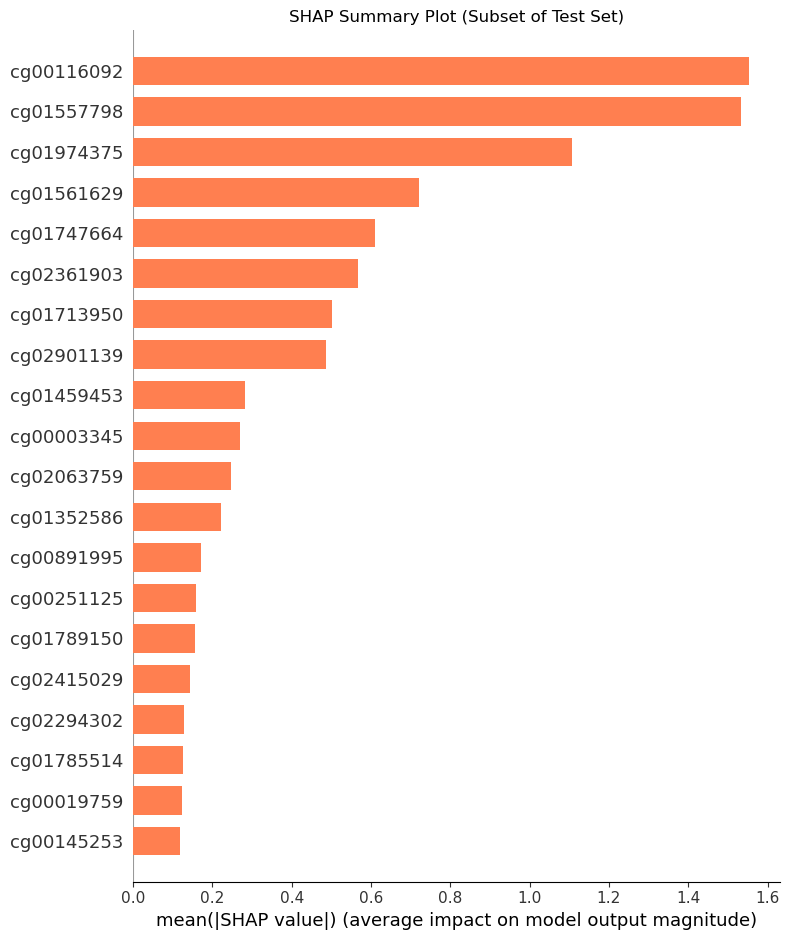

In [26]:
# Compute SHAP values on a subset of the test set
explainer = shap.TreeExplainer(rf)
X_shap = X_test_scaled.sample(100, random_state=500)
shap_values = explainer.shap_values(X_shap)

# SHAP summary bar plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_shap, plot_type="bar", color="coral", show=False)
plt.title("SHAP Summary Plot (Subset of Test Set)")
plt.tight_layout()
plt.savefig("shap_summary_test_subset.png", dpi=300)
plt.show()

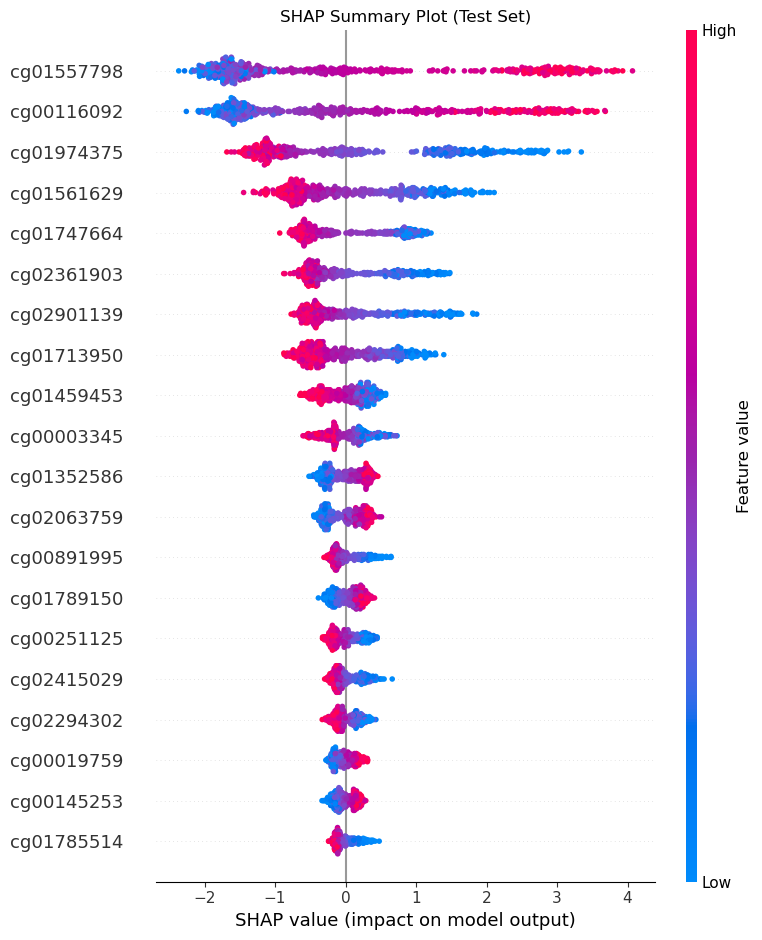

In [27]:
# Compute SHAP values on the full test set
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test_scaled)

# SHAP beeswarm summary plot (default style)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_scaled, show=False)
plt.title("SHAP Summary Plot (Test Set)")
plt.tight_layout()
plt.savefig("shap_summary_test.png", dpi=300)
plt.show()
